## Dataset Lenght of Stay

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records, ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

Importiamo tutte le liblerie necessarie per il Notebook

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split #funzioni per dividere il dataset in test/validation/training set
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
import datetime #fornisce funzioni e classi per lavorare con date e tempi
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator #strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import HTML #funzioni utilizzate per visualizzare output HTML nel notebook
import base64 #fornisce funzioni per codificare e decodificare dati binari in stringhe ASCII utilizzando la codifica base64
import preprocess_dataset as ut
from tfkan import DenseKAN
import networkx as nx
import numpy as np
from scipy.interpolate import BSpline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
import random
import lime
import lime.lime_tabular

In [3]:
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from sklearn.utils import check_random_state
check_random_state(seed_value)

RandomState(MT19937) at 0x19C34414940

# Caricamento del dataset e analisi

Come prima cosa ci salviamo il nome del dataset in una variabile, usiamo un impostazione di pandas che permette di cambiare il tipo degli attributi nel dataset e poi carichimo il dataset in un dataframe pandas 

In [4]:
#variabile contenente il nome del dataset
DATASET_NAME = 'LengthOfStay'

#Consente che si possa cambiare il tipo degli attributi nel dataset
pd.set_option('future.no_silent_downcasting', True)    

#Carica il dataset in un Pandas Dataframe
df = pd.read_csv(f"datasets/{DATASET_NAME}.csv")

Eseguiamo un analisi grafica del dataset osservando la distribuzione dei vari attributi, gli estremi ed eventuali valori mancanti nei record

In [5]:
fsg = FeatureStatisticsGenerator() #Crea un oggetto FeatureStatisticsGenerator, che è una classe di Facets che genera statistiche dai tuoi dati
dataframes = [ {'table': df, 'name': DATASET_NAME}] #Crea un dizionario con dentro il dataframe
censusProto = fsg.ProtoFromDataFrames(dataframes) # Genera le statistiche dal DataFrame
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8") # codifica dei dati del dataset

# Impostazioni per la visualizzazione (mostra degli attributi evidentemente sbilanciati)
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html)) #mostra l'analisi grafica

c:\Users\fraca\miniconda3\envs\DL\Lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Osserviamo che non sono presenti valori mancanti in nessun attributo, ma sono presenti molti attributi sbilanciati nella distribuzione dei loro valori

##### Pre-processing del dataset

Importando il dataset e visualizzando i record ci accorgiamo che ci sono degli attributi non numerici, come date e stringhe, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.

Gli attributi a cui dovremo dare una codifica numerica sono:
- **vdate** e **discharged**: sono la data di inizio e fine del ricovero; si potrebbero codificare come interi da 0 a 365 (o 366 a seconda dell'anno), tuttavia per il nostro scopo è opportuno eliminare queste colonne in quanto permettono di risalire algoritmicamente al target della predizione.
- **rcount**: è il numero di ricoveri pregressi del paziente; trasformeremo il valore 5+ in 5.
- **gender**: è il genere del paziente; trasformeremo M in 0 ed F in 1.
- **facid**: è un identificativo del reparto ospedaliero; trasformeremo le lettere in numeri incrementali.


In [16]:
del df['vdate']; del df['discharged']

df.replace({"rcount": dict(zip(sorted(df["rcount"].unique()), range(6)))}, inplace=True) # Codifica del 5+ in 5 e conversione a interi

df.replace({"gender": {"M":0, "F":1}}, inplace=True) # Codifica binaria del genere, assegna 0 a maschio e 1 a femmina

keys = df["facid"].unique() # Estrazione dei valori unici dell'attributo
ints = {key: value for value, key in enumerate(keys)} # Creazione del dizionario di codifica
df.replace({"facid": ints}, inplace=True) # Codifica del facid


          eid rcount gender  dialysisrenalendstage  asthma  irondef  pneum  \
0           1      0      1                      0       0        0      0   
1           2      5      1                      0       0        0      0   
2           3      1      1                      0       0        0      0   
3           4      0      1                      0       0        0      0   
4           5      0      1                      0       0        0      1   
...       ...    ...    ...                    ...     ...      ...    ...   
99995   99996      3      0                      0       0        0      0   
99996   99997      0      0                      0       0        0      0   
99997   99998      1      0                      0       0        1      0   
99998   99999      0      0                      0       0        0      0   
99999  100000      0      1                      0       0        0      0   

       substancedependence  psychologicaldisordermajor  depress

Separiamo adesso training set, validation set e test set, inoltre creiamo a parte dei dataset per addestrare i modelli di ML poiche essi possono essere allenati su attributi non in forma tensoriale, ma anche categorica

In [17]:
test_ratio = 0.20
val_ratio = 0.20

data_len = len(df)
train_bound = int(data_len*(1-val_ratio-test_ratio))
val_bound = int(data_len*(1-test_ratio))

df_features = df.iloc[:, 1:-1]
df_labels = df.iloc[:, -1]

x_train, y_train = df_features[:train_bound], df_labels[:train_bound]
xtree_train, ytree_train, xtree_test, ytree_test = x_train, y_train, df_features[val_bound:], df_labels[val_bound:]
x_val, y_val = df_features[train_bound:val_bound], df_labels[train_bound:val_bound]


# Creazione dei dataset di train e test
xtree_train.to_csv("datasets/x_train.csv")
ytree_train.to_csv("datasets/y_train.csv")
xtree_test.to_csv("datasets/x_test.csv")
ytree_test.to_csv("datasets/y_test.csv")
x_val.to_csv("datasets/x_val.csv")
y_val.to_csv("datasets/y_val.csv")

tensor_dataset = df.to_numpy()

A questo punto il dataset ha solamente valori numerici e può essere trattato come un tensore.
Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati

In [7]:
#divide le colonne del dataset in attributi e label
features1 = tensor_dataset[:, 1:-1]
labels = tensor_dataset[:, -1]

features1 = tf.convert_to_tensor(ut.standardize(features1), dtype=tf.float32)

#divide i dati in dati in train, validazione e test set
x_train, y_train = features1[:train_bound], labels[:train_bound]
x_val, y_val = features1[train_bound:val_bound], features1[train_bound:val_bound]
x_test, y_test = features1[val_bound:], labels[val_bound:]

print(tf.shape(x_train), tf.shape(x_val), tf.shape(x_test)) #stampa le dimensioni dei nuovi dataset creati

tf.Tensor([60000    26], shape=(2,), dtype=int32) tf.Tensor([20000    26], shape=(2,), dtype=int32) tf.Tensor([20000    26], shape=(2,), dtype=int32)


In [8]:
# Conversione dei dataset a tensori
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

### Definizione architettura KAN Classica

Definiamo un seme casuale per rendere gli esperimenti ripetibili e una funzione pe ril calcolo di rmse

In [9]:
tf.random.set_seed(420)

class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError(name='mse')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        return tf.sqrt(self.mse.result())
        
    def reset_states(self):
        self.mse.reset_states()


# Lista di metrics necessarie per valutare le performance.
METRICS = [
  tf.keras.metrics.MeanSquaredError(name='mse'),
  tf.keras.metrics.MeanAbsoluteError(name='mae'),
  tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

#lista dei modelli addestrati
histories = []
elenco_modelli = []
elenco_modelliML = []

features = [
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'discharged', 'facid'
]


Definizione parametri

In [10]:
HIDDEN_UNITS_LAYER_01 = 5
HIDDEN_UNITS_LAYER_02 = 3
HIDDEN_UNITS_LAYER_03 = 1
LEARNING_RATE = 0.1 
EPOCH = 10


In [11]:

# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(4),
    DenseKAN(1)
])
kan.build(input_shape=(None, 26))
kan.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 4)              │           940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 977 (7.63 KB)

 Trainable params: 977 (7.63 KB)

 Non-trainable params: 0 (0.00 B)

Ora addestriamo la kan:

In [12]:
kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0050089061837515795), loss='mse', metrics=METRICS)

kan_history = kan.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN', kan_history))
elenco_modelli.append(('KAN', kan))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1567 - mae: 1.6641 - mse: 5.1567 - rmse: 2.1839 - val_loss: 0.8960 - val_mae: 0.6849 - val_mse: 0.8960 - val_rmse: 0.9466
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8654 - mae: 0.6719 - mse: 0.8654 - rmse: 0.9299 - val_loss: 0.7307 - val_mae: 0.6145 - val_mse: 0.7307 - val_rmse: 0.8548
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7471 - mae: 0.6198 - mse: 0.7471 - rmse: 0.8643 - val_loss: 0.6901 - val_mae: 0.6027 - val_mse: 0.6901 - val_rmse: 0.8307
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6925 - mae: 0.5966 - mse: 0.6925 - rmse: 0.8321 - val_loss: 0.6571 - val_mae: 0.5909 - val_mse: 0.6571 - val_rmse: 0.8106
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6537 - mae: 0.5795 - mse: 0.6537 - rmse: 0.8085 - val_loss: 0.6340 - val_mae: 0.5820 - val_mse: 0.6340 - val_rmse: 0.7962
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6308 - mae: 0.5697

### Definizione architettura MLP

In [13]:
# MLP
mlp = tf.keras.models.Sequential([
    Dense(HIDDEN_UNITS_LAYER_01),
    Dense(HIDDEN_UNITS_LAYER_02),
    Dense(HIDDEN_UNITS_LAYER_03)
    ])
mlp.build(input_shape=(None, 26))
mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │           135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157 (628.00 B)

 Trainable params: 157 (628.00 B)

 Non-trainable params: 0 (0.00 B)

Addestriamo la MLP:

In [14]:

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

mlp_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('MLP', mlp_history))
elenco_modelli.append(('MLP', mlp))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - loss: 11.3686 - mae: 1.5021 - mse: 5.2359 - rmse: 2.2771 - val_loss: 1.8397 - val_mae: 1.0777 - val_mse: 1.8397 - val_rmse: 1.3563
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 1.5716 - mae: 0.9678 - mse: 1.5716 - rmse: 1.2529 - val_loss: 1.3561 - val_mae: 0.8853 - val_mse: 1.3561 - val_rmse: 1.1645
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 1.3867 - mae: 0.8949 - mse: 1.3867 - rmse: 1.1775 - val_loss: 1.3437 - val_mae: 0.8828 - val_mse: 1.3437 - val_rmse: 1.1592
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 1.3769 - mae: 0.8923 - mse: 1.3769 - rmse: 1.1733 - val_loss: 1.3380 - val_mae: 0.8851 - val_mse: 1.3380 - val_rmse: 1.1567
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 1.3714 - mae: 0.8910 - mse: 1.3714 - rmse: 1.1710 - val_loss: 1.3358 - val_mae: 0.8875 - val_mse: 1.3358 - val_rmse: 1.1558
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 1.3685 

### Definizione architerrura KAN-MLP 1 (Livelli misti)

In [15]:

# Creazione del modello KAN
kanmix1 = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    Dense(HIDDEN_UNITS_LAYER_02),
    DenseKAN(HIDDEN_UNITS_LAYER_03)
])
kanmix1.build(input_shape=(None, 26))
kanmix1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_2 (DenseKAN)          │ (None, 5)              │         1,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_3 (DenseKAN)          │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221 (9.47 KB)

 Trainable params: 1,221 (9.47 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [16]:

kanmix1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

kanmix1_history = kanmix1.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN_MIX1', kanmix1_history))
elenco_modelli.append(('KAN_MIX1', kanmix1))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 13.4192 - mae: 1.8845 - mse: 7.2257 - rmse: 2.6710 - val_loss: 2.5929 - val_mae: 1.1671 - val_mse: 2.5929 - val_rmse: 1.6102
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8379 - mae: 0.9604 - mse: 1.8379 - rmse: 1.3512 - val_loss: 0.9430 - val_mae: 0.6924 - val_mse: 0.9430 - val_rmse: 0.9711
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9094 - mae: 0.6759 - mse: 0.9094 - rmse: 0.9535 - val_loss: 0.8142 - val_mae: 0.6578 - val_mse: 0.8142 - val_rmse: 0.9023
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8046 - mae: 0.6429 - mse: 0.8046 - rmse: 0.8969 - val_loss: 0.7556 - val_mae: 0.6346 - val_mse: 0.7556 - val_rmse: 0.8693
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7573 - mae: 0.6250 - mse: 0.7573 - rmse: 0.8702 - val_loss: 0.7197 - val_mae: 0.6194 - val_mse: 0.7197 - val_rmse: 0.8484
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7259 - mae: 0.612

### Definizione architerrura KAN-MLP 2 (Livelli consecutivi)

In [17]:
# Creazione del modello KAN
kanmix2 = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02),
    Dense(HIDDEN_UNITS_LAYER_03)
])
kanmix2.build(input_shape=(None, 26))
kanmix2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_4 (DenseKAN)          │ (None, 5)              │         1,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_5 (DenseKAN)          │ (None, 3)              │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317 (10.27 KB)

 Trainable params: 1,317 (10.27 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [18]:

kanmix2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

kanmix2_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN_MIX2', kanmix2_history))
elenco_modelli.append(('KAN_MIX2', kanmix2))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 1.3663 - mae: 0.8891 - mse: 1.3663 - rmse: 1.1688 - val_loss: 1.3342 - val_mae: 0.8885 - val_mse: 1.3342 - val_rmse: 1.1551
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 1.3663 - mae: 0.8891 - mse: 1.3663 - rmse: 1.1688 - val_loss: 1.3342 - val_mae: 0.8885 - val_mse: 1.3342 - val_rmse: 1.1551
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 1.3663 - mae: 0.8891 - mse: 1.3663 - rmse: 1.1688 - val_loss: 1.3343 - val_mae: 0.8885 - val_mse: 1.3343 - val_rmse: 1.1551
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 1.3663 - mae: 0.8891 - mse: 1.3663 - rmse: 1.1688 - val_loss: 1.3343 - val_mae: 0.8885 - val_mse: 1.3343 - val_rmse: 1.1551
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 1.3663 - mae: 0.8891 - mse: 1.3663 - rmse: 1.1688 - val_loss: 1.3343 - val_mae: 0.8886 - val_mse: 1.3343 - val_rmse: 1.1551
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 1.3663 -

### Definizione architettura Albero

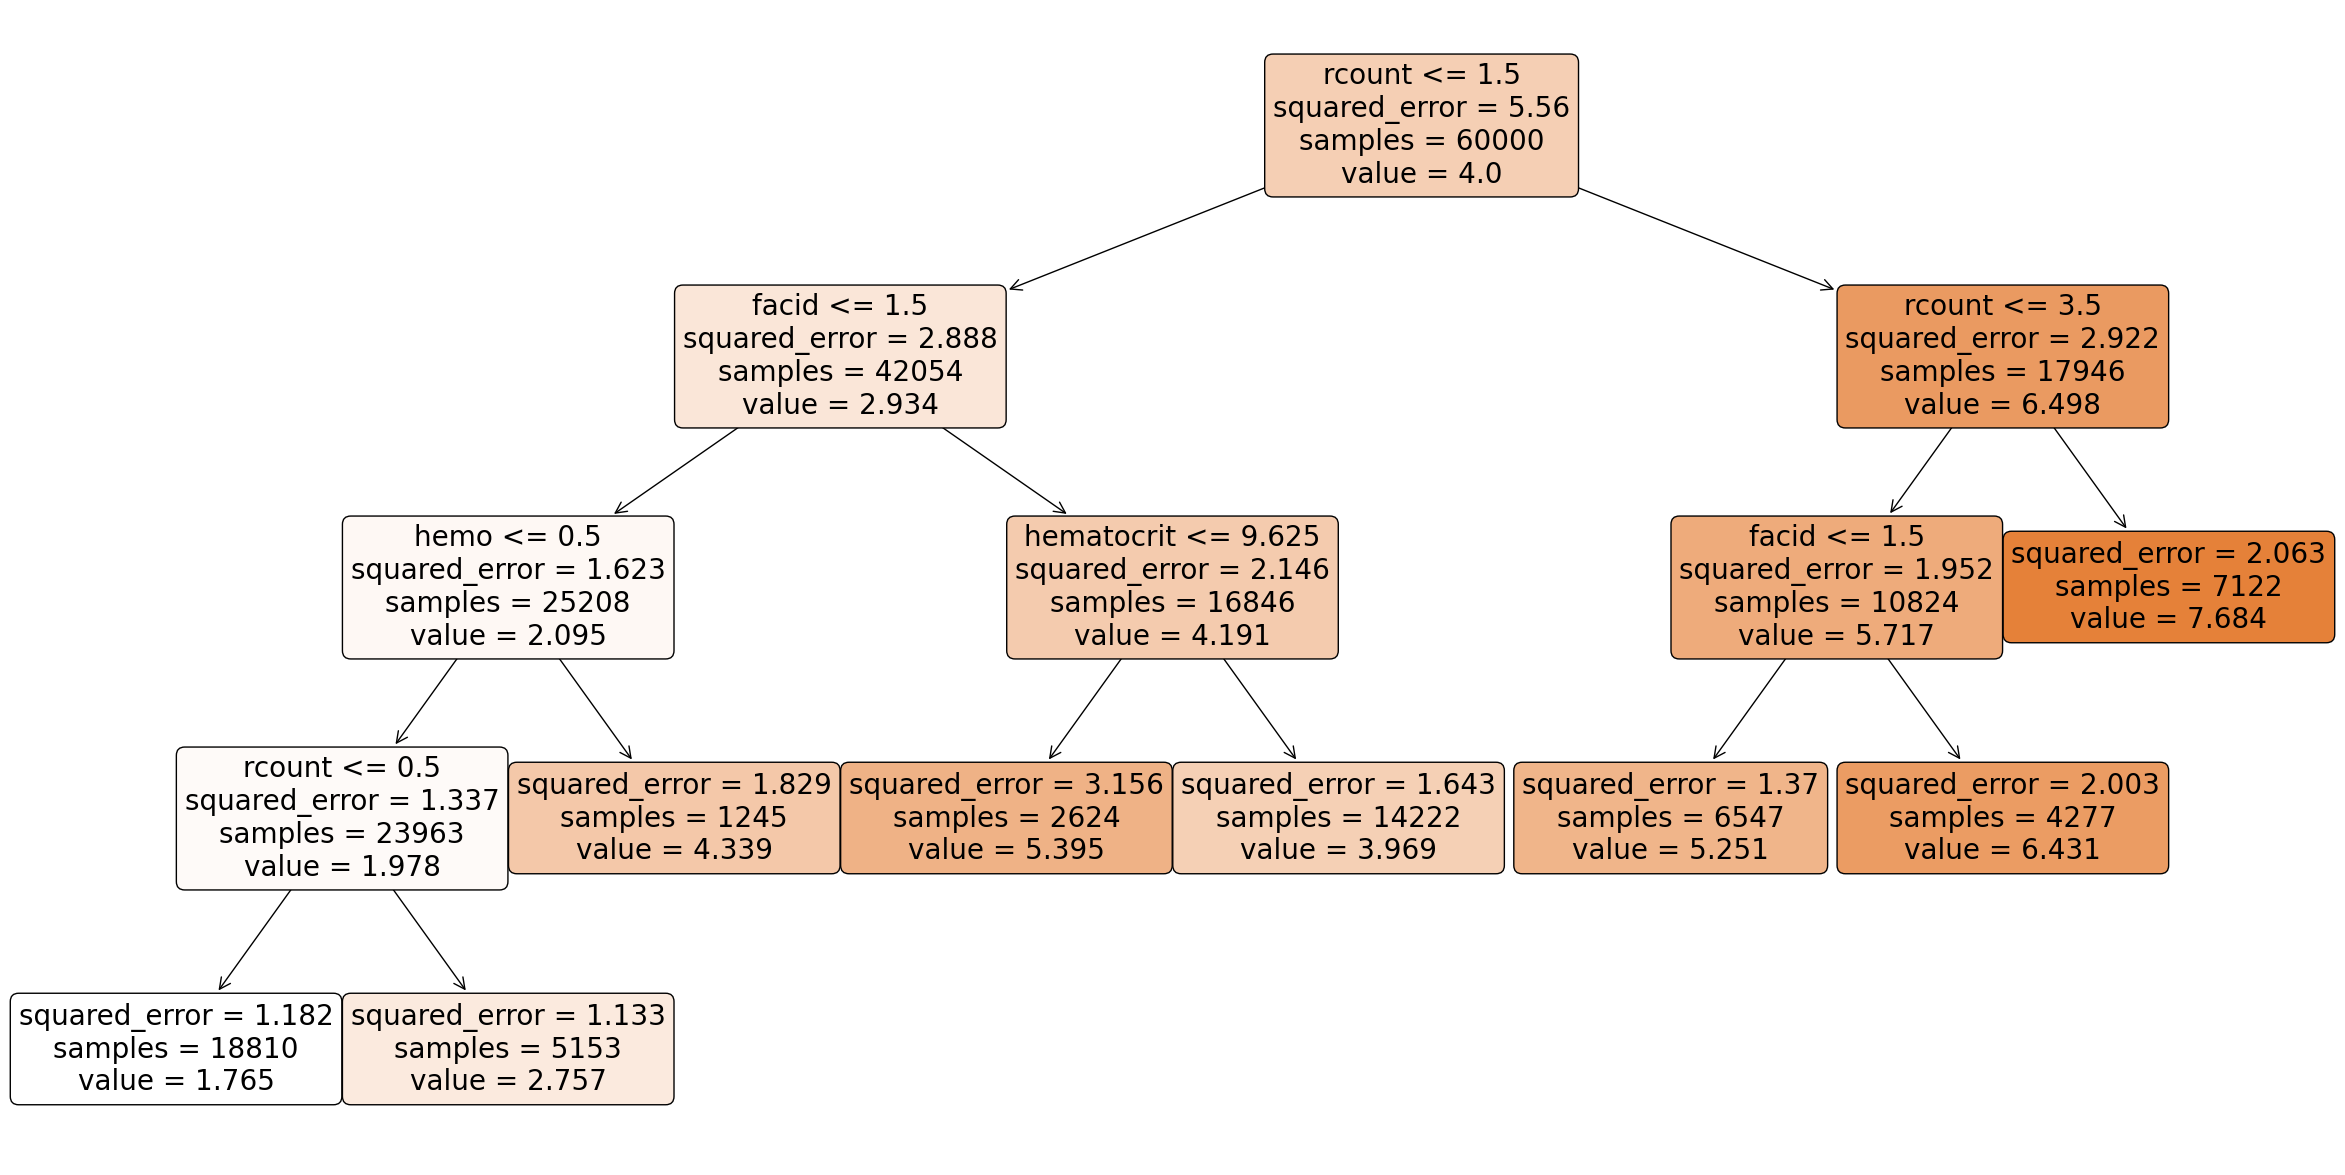

In [19]:
from math import sqrt

# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(max_depth= 5, ccp_alpha=0.05, min_samples_split=4, random_state=0)
tree.fit(xtree_train, ytree_train)


y_pred = tree.predict(xtree_test)

# Calcola MAE, MSE e RMSE
mae = mean_absolute_error(ytree_test, y_pred)
mse = mean_squared_error(ytree_test, y_pred)
rmse = sqrt(mse)

# Aggiungi i calcoli alla lista 'elenco_modelli'
elenco_modelliML.append(('TREE', tree))

# Crea una figura
plt.figure(figsize=(30,15))

# Disegna l'albero
plot_tree(tree, max_depth=5, filled=True, rounded=True, feature_names=features)

# Mostra il plot
plt.show()


### Definizione architettura Foresta

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

forest = RandomForestRegressor()

forest.set_params(n_estimators=100, max_depth=10)

forest.fit(xtree_train, ytree_train)


y_pred = forest.predict(xtree_test)

# Calcola MAE, MSE e RMSE
mae = mean_absolute_error(ytree_test, y_pred)
mse = mean_squared_error(ytree_test, y_pred)
rmse = sqrt(mse)

# Aggiungi i calcoli alla lista 'elenco_modelli'
elenco_modelliML.append(('FOREST', forest))

### Definizione architettura Ensemble

In [21]:

# Crea i modelli individuali
tree1 = DecisionTreeRegressor(max_depth=5, ccp_alpha=0.05, min_samples_split=4, random_state=0)
linear = LinearRegression()
bayes = BayesianRidge()

# Crea il modello di ensemble
ensemble = VotingRegressor(estimators=[('tree', tree1), ('linear', linear), ('bayes', bayes)])

# Allena il modello utilizzando i dati di addestramento
ensemble.fit(xtree_train, ytree_train)


y_pred = ensemble.predict(xtree_test)

# Calcola MAE, MSE e RMSE
mae = mean_absolute_error(ytree_test, y_pred)
mse = mean_squared_error(ytree_test, y_pred)
rmse = sqrt(mse)

# Aggiungi i calcoli alla lista 'elenco_modelli'
elenco_modelliML.append(('ENSEMBLE', ensemble))


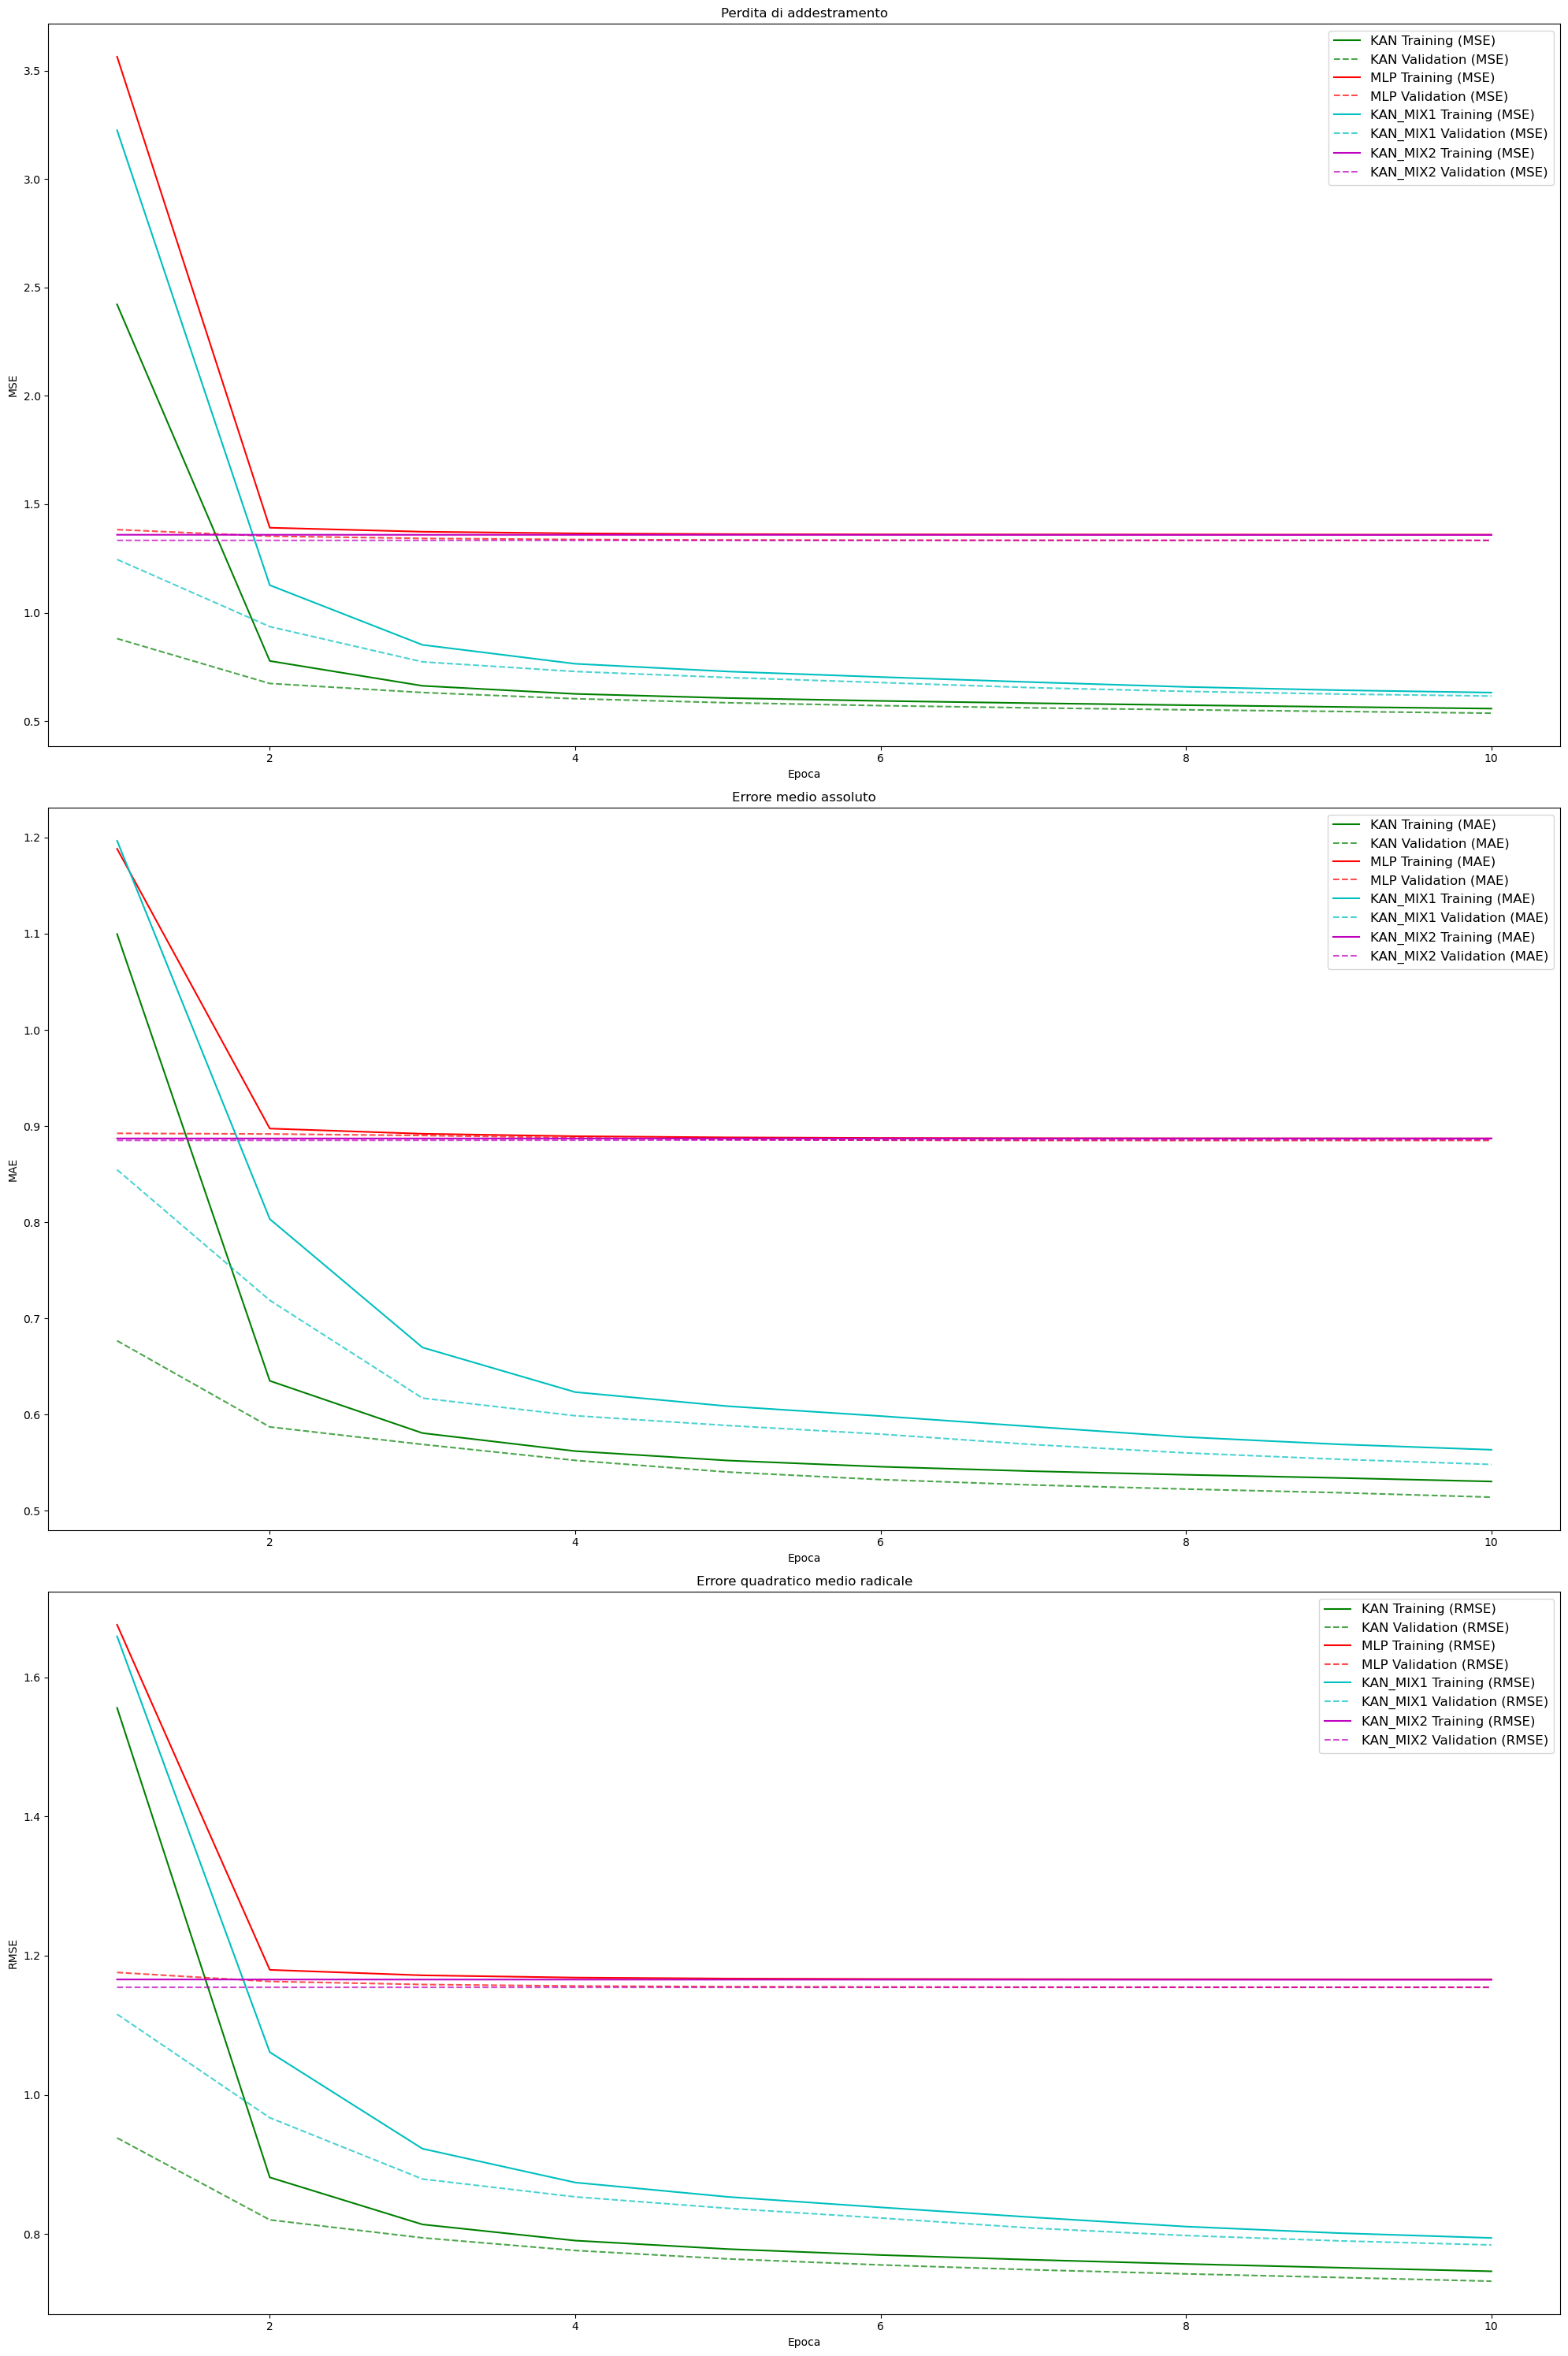

In [45]:
# Crea una lista di colori
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'purple']

plt.figure(figsize=(20, 30))
i=0


for model_name, history in histories:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    rmse = history.history['rmse']
    val_rmse = history.history['val_rmse']
    i += 1
    epochs = range(1, len(loss) + 1)

    # Usa lo stesso colore per il training e il validation set di ogni modello
    color = colors[i % len(colors)]

    plt.subplot(3, 1, 1)
    plt.plot(epochs, loss, color, label=f'{model_name} Training (MSE)') 
    plt.plot(epochs, val_loss, color+'--', alpha=0.7, label=f'{model_name} Validation (MSE)') 
    plt.title('Perdita di addestramento')
    plt.xlabel('Epoca')
    plt.ylabel('MSE')
    plt.legend(fontsize='large')

    plt.subplot(3, 1, 2)
    plt.plot(epochs, mae, color, label=f'{model_name} Training (MAE)') 
    plt.plot(epochs, val_mae, color+'--', alpha=0.7, label=f'{model_name} Validation (MAE)') 
    plt.title('Errore medio assoluto')
    plt.xlabel('Epoca')
    plt.ylabel('MAE')
    plt.legend(fontsize='large')

    plt.subplot(3, 1, 3)
    plt.plot(epochs, rmse, color, label=f'{model_name} Training (RMSE)') 
    plt.plot(epochs, val_rmse, color+'--', alpha=0.7, label=f'{model_name} Validation (RMSE)') 
    plt.title('Errore quadratico medio radicale')
    plt.xlabel('Epoca')
    plt.ylabel('RMSE')
    plt.legend(fontsize='large')

plt.tight_layout()
plt.show()


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


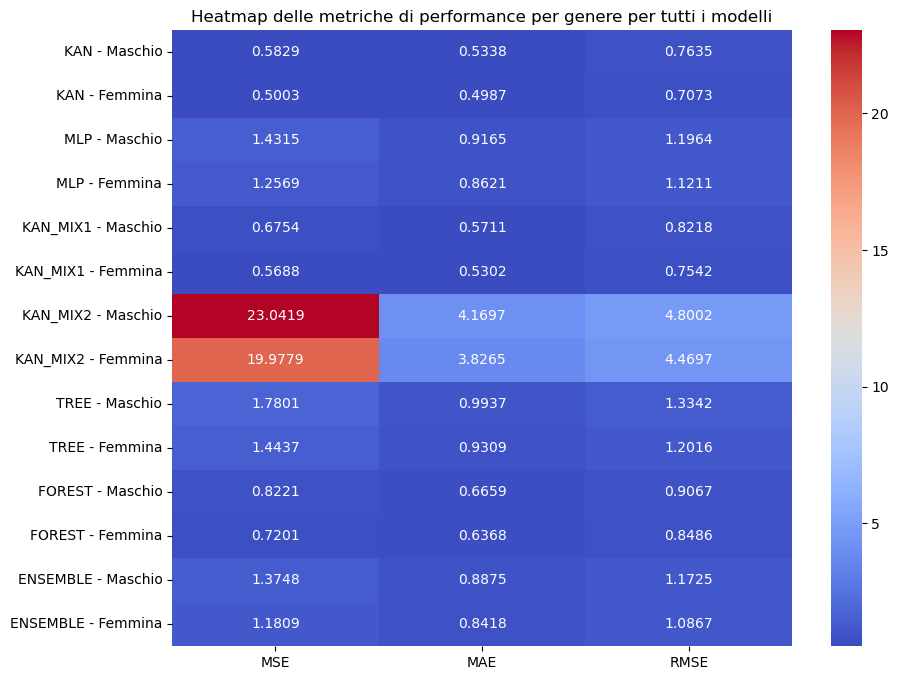

In [46]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina
SUBGROUPSML = ['M', 'F']  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
all_results = {}

# Per ogni modello nella tua lista 'elenco_modelli'
for model_name, model in elenco_modelli:
    results = {}
    for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
        
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = x_test[:, CATEGORY] == sg
        features1 = x_test[subgroup_indices]
        labels = y_test[subgroup_indices]
        
        # Calcolo delle previsioni del modello sul sottogruppo corrente
        predictions = model.predict(features1)
        
        # Calcolo delle metriche personalizzate per ciascun sottogruppo
        mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
        mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
        rmse_value = np.sqrt(mse_value)
        
        # Memorizzazione dei risultati
        results[sg] = [mse_value, mae_value, rmse_value]

    # Aggiungi i risultati di questo modello ai risultati totali
    all_results[model_name] = results

for model_name, model in elenco_modelliML:
    results = {}  # Inizializzazione di `results` per ogni modello ML
    for sg in SUBGROUPS:  # per ogni gruppo nell'elenco dei sottogruppi
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = xtree_test.iloc[:, CATEGORY] == sg
        
        features1 = xtree_test[subgroup_indices]
        labels = ytree_test[subgroup_indices]
        
        # Calcolo delle previsioni del modello sul sottogruppo corrente
        predictions = model.predict(features1)
        
        # Calcolo delle metriche personalizzate per ciascun sottogruppo
        mse_value = mean_squared_error(labels, predictions)
        mae_value = mean_absolute_error(labels, predictions)
        rmse_value = np.sqrt(mse_value)
        
        # Memorizzazione dei risultati
        results[sg] = [mse_value, mae_value, rmse_value]
    
    # Aggiungi i risultati di questo modello ai risultati totali
    all_results[model_name] = results



# Creazione di un DataFrame per visualizzare le metriche di performance di tutti i modelli
df = pd.DataFrame()

for model_name, results in all_results.items():
    temp_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
    temp_df.columns = [f'{model_name} - Maschio', f'{model_name} - Femmina']
    df = pd.concat([df, temp_df], axis=1)

# Conversione dei dati in float
df = df.astype(float)

# Trasposizione del DataFrame per invertire righe e colonne
df = df.transpose()

# Calcolo dei valori minimi e massimi per la scala di colori
vmin = df.min().min()
vmax = df.max().max()

# Creazione della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere per tutti i modelli')
plt.show()



In [47]:

# Lista delle caratteristiche
def calculate_feature_importance(model, x_val, y_val):
    # Calcola l'importanza delle caratteristiche
    results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')
    # Ottieni l'importanza delle caratteristiche
    importance = results.importances_mean
    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))
    return feature_importance


def calculate_feature_importanceML(model, x_val, y_val):
    # Verifica se il modello ha l'attributo 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        # Utilizza l'attributo 'feature_importances_' per i modelli basati su alberi
        importance = model.feature_importances_
    else:
        # Altrimenti, utilizza la 'permutation_importance'
        results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')
        importance = results.importances_mean
    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))
    return feature_importance


caratteristiche = []
for nome, modello in elenco_modelli:
    caratteristiche.append((nome, calculate_feature_importance(modello, x_test, y_test)))

for nome, modello in elenco_modelliML:
    caratteristiche.append((nome, calculate_feature_importanceML(modello, xtree_test, ytree_test)))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
625/625 ━━━

In [48]:
def stampa_importanza_caratteristiche(caratteristiche):
    for nome_modello, importanza_caratteristiche in caratteristiche:
        print(f"Modello: {nome_modello}")
        totale = 0
        for valus in importanza_caratteristiche.values():
            totale += abs(valus)
        
        for caratteristica, importanza in importanza_caratteristiche.items():
            print(f"Caratteristica: {caratteristica}, Importanza: {((importanza / totale)):.2f}")
        print("\n")

stampa_importanza_caratteristiche(caratteristiche)


Modello: KAN
Caratteristica: vdate, Importanza: 0.00
Caratteristica: rcount, Importanza: 0.65
Caratteristica: gender, Importanza: 0.00
Caratteristica: dialysis, Importanza: 0.01
Caratteristica: asthma, Importanza: 0.01
Caratteristica: irondef, Importanza: 0.03
Caratteristica: pneum, Importanza: 0.01
Caratteristica: subdep, Importanza: 0.02
Caratteristica: psychmaj, Importanza: 0.08
Caratteristica: depress, Importanza: 0.01
Caratteristica: psychother, Importanza: 0.01
Caratteristica: fibrosis, Importanza: 0.00
Caratteristica: malnutr, Importanza: 0.01
Caratteristica: hemo, Importanza: 0.03
Caratteristica: hematocrit, Importanza: 0.02
Caratteristica: neutrophils, Importanza: 0.00
Caratteristica: sodium, Importanza: 0.02
Caratteristica: glucose, Importanza: 0.02
Caratteristica: bun, Importanza: 0.00
Caratteristica: creatinine, Importanza: 0.02
Caratteristica: bmi, Importanza: 0.02
Caratteristica: pulse, Importanza: 0.02
Caratteristica: respiration, Importanza: 0.02
Caratteristica: secdiag

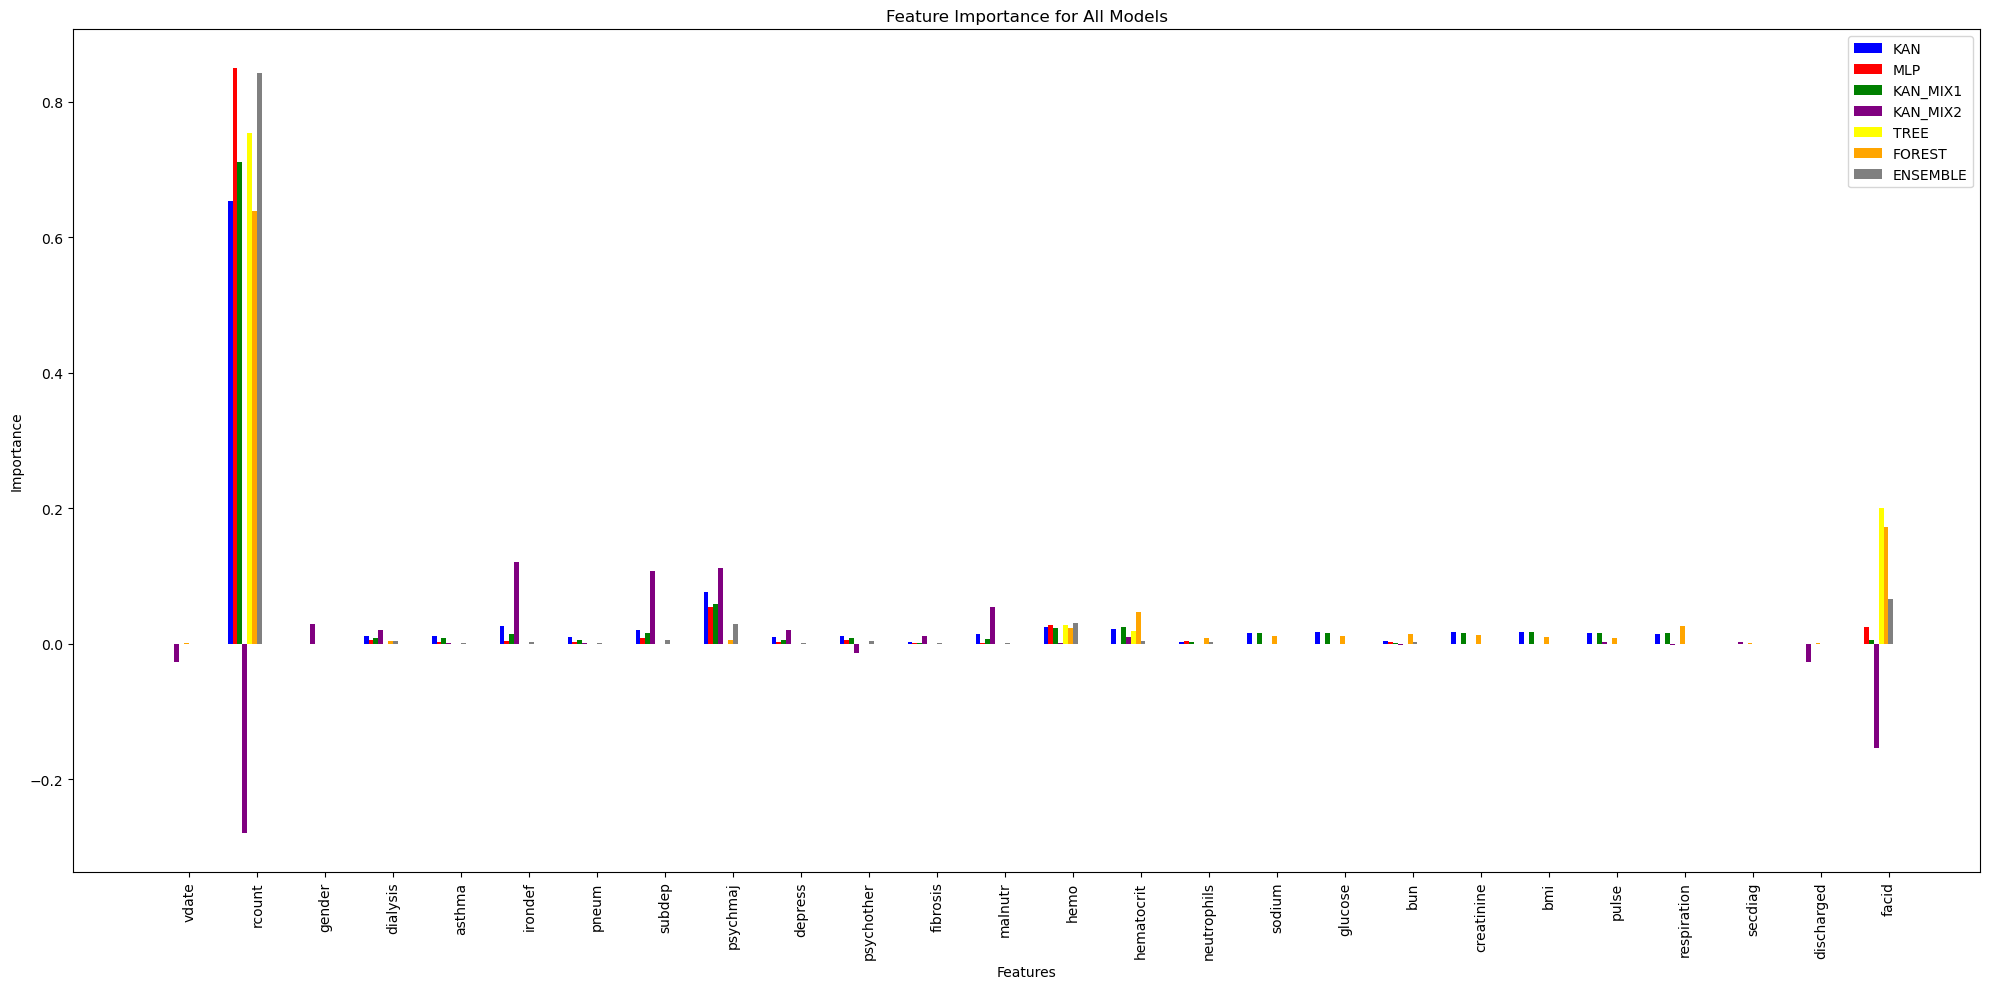

In [49]:


# Inizializza i dizionari per l'importanza delle caratteristiche
importanze = {}

# Calcola l'importanza delle caratteristiche per ogni modello
for nome, importanza in caratteristiche:
    importanze[nome] = {}
    totale = sum(abs(imp) for imp in importanza.values())
    for feature, importance in importanza.items():
        importanze[nome][feature] = importance / totale

# Crea le etichette per l'asse x
features = list(importanze[list(importanze.keys())[0]].keys())
x = np.arange(len(features))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(20, 10))  # Modifica le dimensioni qui

# Calcola la larghezza delle barre in base al numero di modelli
bar_width = 0.5 / len(importanze)

# Crea le barre per l'importanza delle caratteristiche per ogni modello
colors = ['blue', 'red', 'green', 'purple', 'yellow', 'orange', 'grey']  
for i, (nome, importanza) in enumerate(importanze.items()):
    ax.bar(x - 0.4 + i * bar_width, list(importanza.values()), bar_width, label=nome, color=colors[i % len(colors)])

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for All Models')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)

ax.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


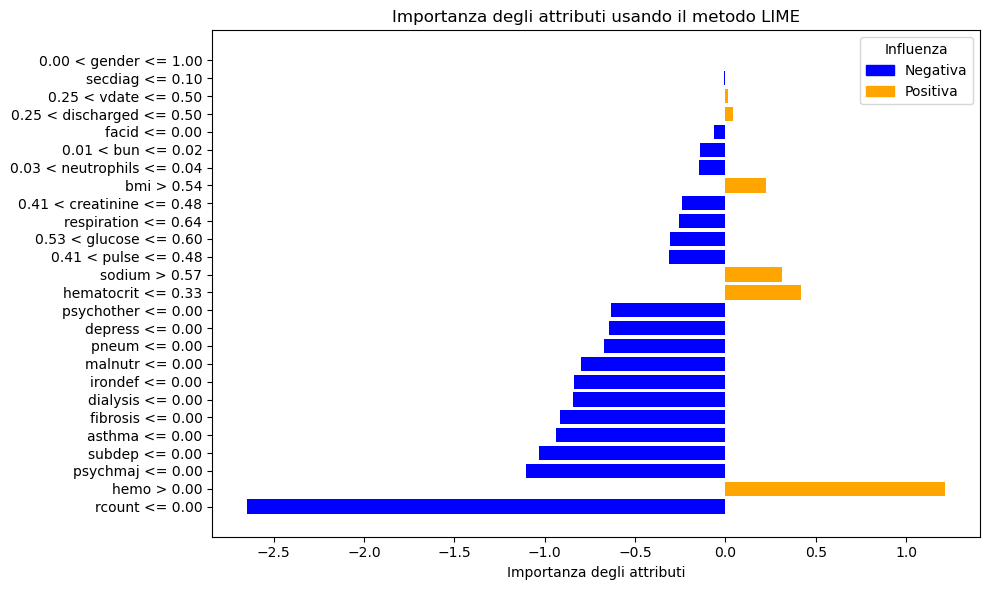

"\n# Genera la spiegazione\nexplanation = explainer.explain_instance(\n    instance_to_explain, \n    kan_predict, \n    num_features=len(features_names)\n)\n\n# Puoi anche ottenere i valori delle feature importance\nfeature_importance = explanation.as_list()\nattributi, importances = zip(*feature_importance)\ncolors = ['blue' if imp < 0 else 'orange' for imp in importances]  # Assegna i colori in base al segno dell'importanza\n\n# Ordina le barre in base all'importanza\nattributi, importances, colors = zip(*sorted(zip(attributi, importances, colors), key=lambda x: x[1]))\n\nfig, ax = plt.subplots(figsize=(10, 6))\nbars = ax.barh(range(len(attributi)), importances, color=colors, height=0.5)  # Aggiungi i colori alle barre e riduci l'altezza delle barre\n\n# Crea gli handle per la leggenda\nhandles = [plt.Rectangle((0,0),1,1, color=color) for color in ['blue', 'orange']]\n\nax.set_yticks(range(len(attributi)))\nax.set_yticklabels(attributi)\nax.set_xlabel('Importanza degli attributi')\n

In [26]:
features_names = features

# Converti i tensori in array numpy
x_train_np = x_train.numpy()
x_test_np = x_test.numpy()

# Crea l'oggetto explainer di LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train_np,
    feature_names=features_names,
    class_names=['target'],
    mode='regression'
)

# Funzione per fare previsioni con il modello KAN
def kan_predict(input_data):
    return kan.predict(input_data)

# Scegli un'istanza da spiegare casualmente dal set di test
instance_to_explain = x_test_np[random.randint(0, len(x_test_np)-1)]  # Scegli un indice casuale

# Genera la spiegazione
explanation = explainer.explain_instance(
    instance_to_explain, 
    kan_predict, 
    num_features=len(features_names)
)

# Puoi anche ottenere i valori delle feature importance
feature_importance = explanation.as_list()
attributi, importances = zip(*feature_importance)
colors = ['blue' if imp < 0 else 'orange' for imp in importances]  # Assegna i colori in base al segno dell'importanza
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(range(len(attributi)), importances, color=colors)  # Aggiungi i colori alle barre

# Crea gli handle per la leggenda
handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['blue', 'orange']]

ax.set_yticks(range(len(attributi)))
ax.set_yticklabels(attributi)
ax.set_xlabel('Importanza degli attributi')
ax.set_title('Importanza degli attributi usando il metodo LIME')
ax.set_facecolor('white')  # Aggiungi uno sfondo bianco
plt.legend(handles, ['Negativa', 'Positiva'], title='Influenza', loc='upper right')  # Aggiungi una leggenda
fig.tight_layout()
plt.show()



"""
# Genera la spiegazione
explanation = explainer.explain_instance(
    instance_to_explain, 
    kan_predict, 
    num_features=len(features_names)
)

# Puoi anche ottenere i valori delle feature importance
feature_importance = explanation.as_list()
attributi, importances = zip(*feature_importance)
colors = ['blue' if imp < 0 else 'orange' for imp in importances]  # Assegna i colori in base al segno dell'importanza

# Ordina le barre in base all'importanza
attributi, importances, colors = zip(*sorted(zip(attributi, importances, colors), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(range(len(attributi)), importances, color=colors, height=0.5)  # Aggiungi i colori alle barre e riduci l'altezza delle barre

# Crea gli handle per la leggenda
handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['blue', 'orange']]

ax.set_yticks(range(len(attributi)))
ax.set_yticklabels(attributi)
ax.set_xlabel('Importanza degli attributi')
ax.set_title('Importanza degli attributi usando il metodo LIME')
ax.set_facecolor('white')  # Aggiungi uno sfondo bianco
ax.grid(axis='x', linestyle='--', alpha=0.7)  # Aggiungi una griglia
plt.legend(handles, ['Negativa', 'Positiva'], title='Influenza', loc='upper right')  # Aggiungi una leggenda
fig.tight_layout()
plt.show()
"""

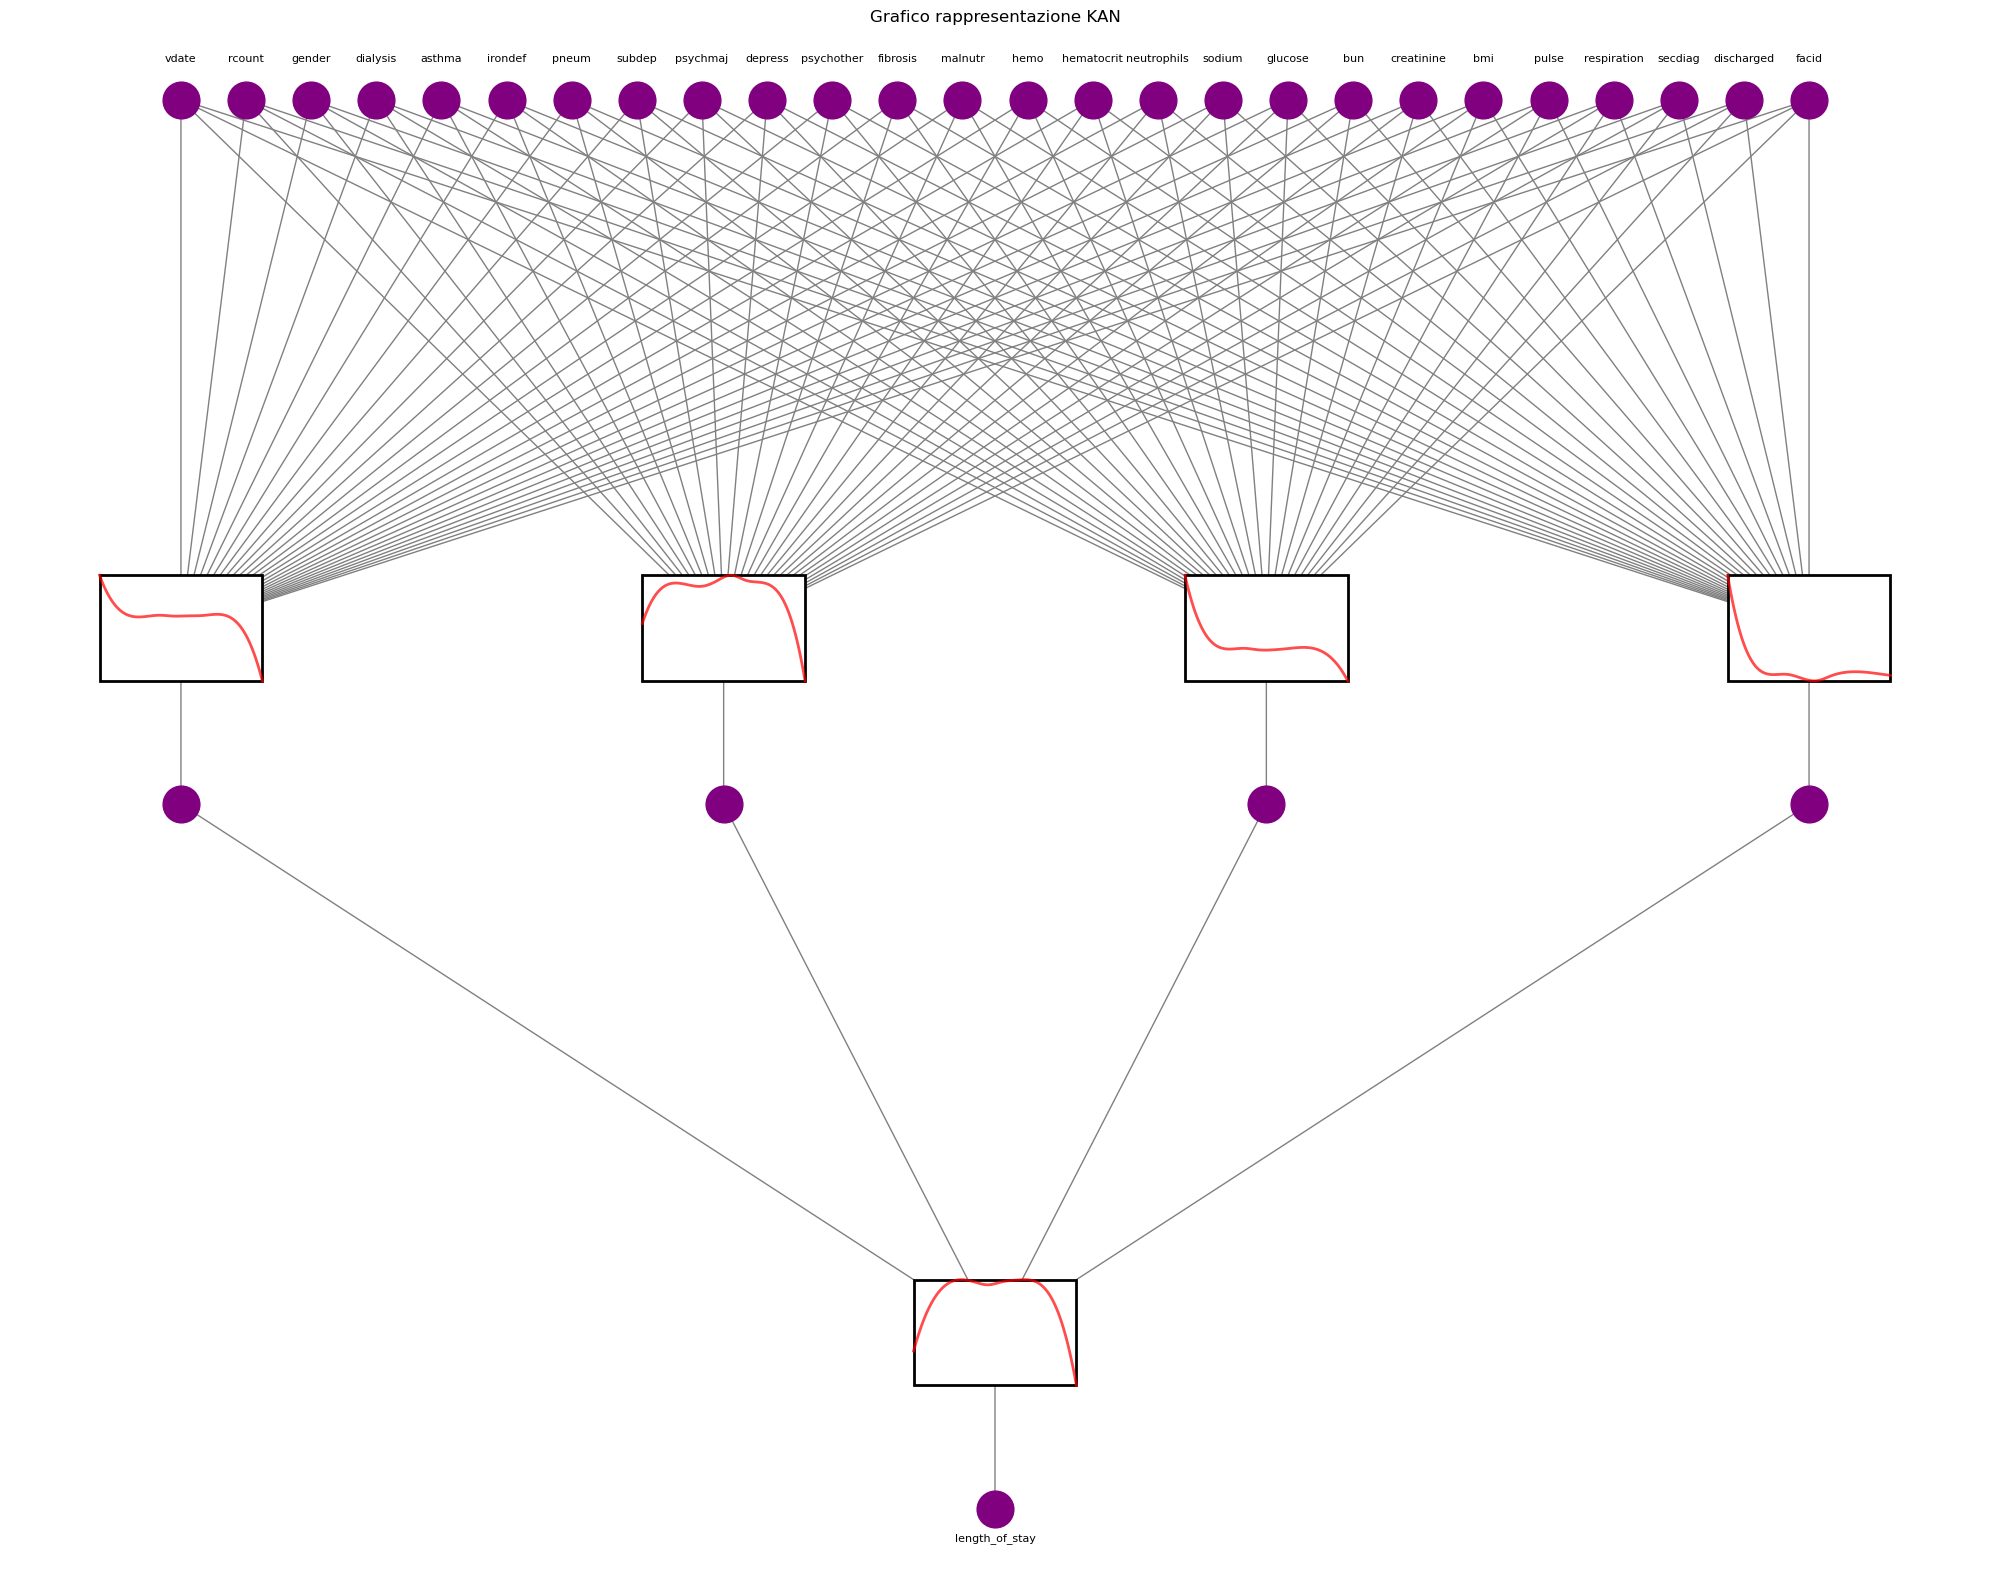

In [62]:
def get_all_splines_from_model(model):
    all_splines = []
    for layer in model.layers:
        if isinstance(layer, DenseKAN):
            all_splines.extend(layer.spline_list)
    return all_splines

def create_kan_tree_from_model(model, features):
    G = nx.DiGraph()
    
    # Add input nodes
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Add hidden and output layers
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        prev_layer_units = len(features) if layer_idx == 0 else model.layers[layer_idx-1].units
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")
    
    return G

def draw_merged_edges(G, pos, ax, kan, edge_color='gray'):
    merge_points = []
    for target in G.nodes():
        in_edges = list(G.in_edges(target))
        if len(in_edges) > 1:
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[in_edges[0][0]][1] - target_pos[1]) / 4])
            merge_points.append(merge_point)
            
            for source, _ in in_edges:
                start = np.array(pos[source])
                ax.annotate("", xy=merge_point, xytext=start, arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"), zorder=1)
            
            ax.annotate("", xy=target_pos, xytext=merge_point, arrowprops=dict(arrowstyle="-", color=edge_color), zorder=1)
    
    spline_collection = get_all_splines_from_model(kan)
    square_size = 0.1  # Fixed square size
    for i, point in enumerate(merge_points):
        if i < len(spline_collection):
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2, fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Draw B-spline within the square
            spl = spline_collection[i]
            xx = np.linspace(spl.t[0], spl.t[-1], 100)
            yy = spl(xx)
            
            # Normalize B-spline values to fit the square
            xx_norm = (xx - np.min(xx)) / (np.max(xx) - np.min(xx)) * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) * (square_size / 2) + (point[1] - square_size / 4)
            
            ax.plot(xx_norm, yy_norm, color='#FF0000', lw=2, alpha=0.7, zorder=3)
    
    return merge_points

# Create graph from model
G = create_kan_tree_from_model(kan, features)

# Setup plot
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')

# Draw edges and squares with B-splines
merge_points = draw_merged_edges(G, pos, ax, kan)

# Draw nodes
node_collection = nx.draw_networkx_nodes(G, pos, node_size=700, node_color='purple', ax=ax)
node_collection.set_zorder(4)  # Set zorder for nodes

# Add labels
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

# Add "length_of_stay" label below the lowest node
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
ax.text(pos[lowest_node][0], pos[lowest_node][1] - 0.015, "length_of_stay", fontsize=8, ha='center')

plt.title("Grafico rappresentazione KAN")
plt.axis('off')
plt.tight_layout()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step


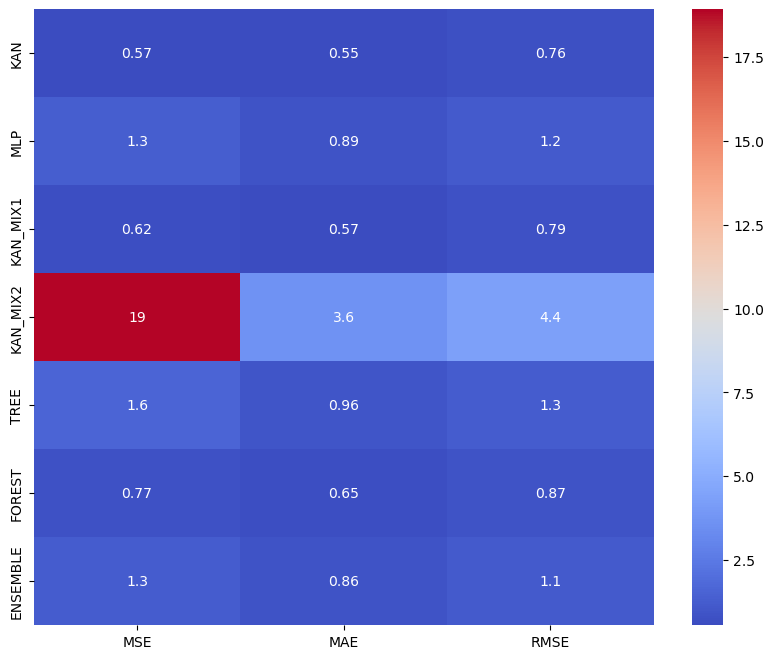

In [22]:

def calculate_metrics(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = root_mean_squared_error(y, predictions)
    return mse, mae, rmse

def performance_heatmap(models, modelsML, X, y, x1, y1):
    metrics = ['MSE', 'MAE', 'RMSE']
    performance = {metric: [] for metric in metrics}
    model_names = []

    for model_name, model in models:
        mse, mae, rmse = calculate_metrics(model, X, y)
        performance['MSE'].append(mse)
        performance['MAE'].append(mae)
        performance['RMSE'].append(rmse)
        model_names.append(model_name)

    for model_name, model in modelsML:
        mse, mae, rmse = calculate_metrics(model, x1, y1)
        performance['MSE'].append(mse)
        performance['MAE'].append(mae)
        performance['RMSE'].append(rmse)
        model_names.append(model_name)

    df = pd.DataFrame(performance, index=model_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm')
    plt.show()

performance_heatmap(elenco_modelli, elenco_modelliML, x_test, y_test, xtree_test, ytree_test)
